Répertoire de données configuré : /Users/sloutmyv/Documents/Github/crypto-ai-bot-v1/data


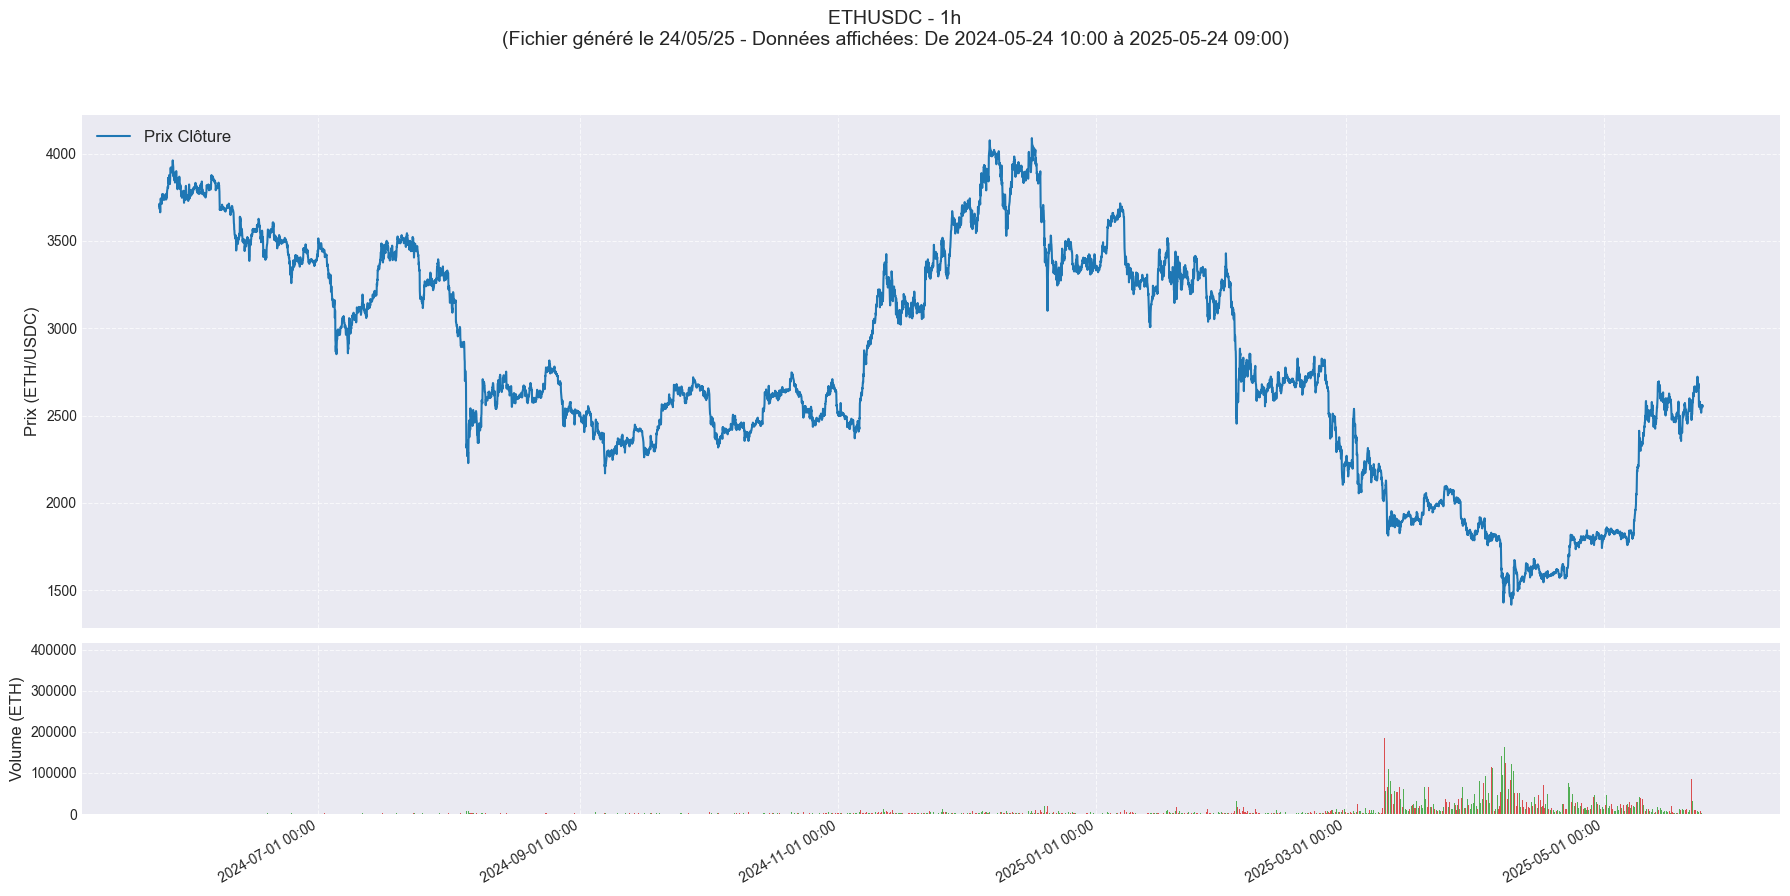

In [ ]:
# Importer les bibliothèques nécessaires
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Pour le formatage des dates
import ipywidgets as widgets # Pour les widgets interactifs
from ipywidgets import interact, interactive, fixed, HBox, VBox # Outils supplémentaires
from IPython.display import display, clear_output # Pour gérer l'affichage des widgets
import datetime # Pour les widgets de date
import re # Pour une validation plus robuste de la date dans le nom de fichier

# --- Configuration Globale ---
try:
    NOTEBOOK_DIR = Path(__file__).resolve().parent
except NameError:
    NOTEBOOK_DIR = Path.cwd()

DATA_DIR = NOTEBOOK_DIR.parent / "data" # Assurez-vous que cela pointe vers votre dossier "data"

print(f"Répertoire de données configuré : {DATA_DIR}")
if not DATA_DIR.exists():
    print(f"⚠️  ATTENTION: Le répertoire de données {DATA_DIR} n'a pas été trouvé.")

# --- Styles Matplotlib ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({
    'figure.figsize': (16, 8),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.family': 'sans-serif',
    'axes.labelsize': 12,
    'axes.titlesize': 16,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 12,
})

# --- Scan des fichiers et préparation des options des widgets ---
available_files = sorted(list(DATA_DIR.glob("*.parquet")))
parsed_files_info = {}
date_pattern = re.compile(r"^\d{6}$")

for f_path in available_files:
    parts = f_path.stem.split('_')
    if 'ta' in parts:
        continue
    if len(parts) == 4:
        symbol_part, interval_part, days_part, date_part = parts
        if days_part.endswith('d') and date_pattern.match(date_part):
            symbol = symbol_part.upper()
            interval = interval_part
            days_str = days_part.replace('d', '')
            file_gen_date_str = date_part
            try:
                days = int(days_str)
                file_key = f"{symbol}_{interval}_{days}d_{file_gen_date_str}"
                parsed_files_info[file_key] = {
                    'symbol': symbol, 'interval': interval, 'days': days,
                    'file_gen_date': file_gen_date_str, 'path': f_path
                }
            except ValueError:
                print(f"Ignoré : 'days' non conforme dans {f_path.name}")
        # else:
            # print(f"Ignoré (format interne non conforme) : {f_path.name}")
    # else:
        # if len(parts) > 0 and not parts[0].startswith('.'):
            # print(f"Ignoré (nombre de parties inattendu) : {f_path.name}")

file_options = {
    f"{info['symbol']} - {info['interval']} - {info['days']}j (gén: {info['file_gen_date'][4:6]}/{info['file_gen_date'][2:4]}/{info['file_gen_date'][0:2]})": key
    for key, info in parsed_files_info.items()
}
sorted_file_options_display = sorted(
    file_options.keys(),
    key=lambda x: (
        parsed_files_info[file_options[x]]['symbol'],
        parsed_files_info[file_options[x]]['interval'],
        parsed_files_info[file_options[x]]['days'],
        parsed_files_info[file_options[x]]['file_gen_date']
    )
)

# --- Définition des Widgets ---
file_selector_widget = widgets.Dropdown(
    options=sorted_file_options_display, description='Fichier Parquet:',
    style={'description_width': 'initial'}, layout={'width': 'max-content'}
)
start_date_widget = widgets.DatePicker(description='Date de début:', disabled=False)
end_date_widget = widgets.DatePicker(description='Date de fin:', disabled=False)
load_button = widgets.Button(
    description="Charger et Afficher", button_style='info',
    tooltip='Cliquez pour charger les données et afficher le graphique', icon='area-chart'
)
output_area = widgets.Output()
current_df = None

# --- Fonctions de Callback ---
def update_date_pickers_range(*args):
    global current_df
    with output_area:
        selected_file_display_name = file_selector_widget.value
        if not selected_file_display_name:
            start_date_widget.value, end_date_widget.value, current_df = None, None, None
            return

        selected_file_key = file_options.get(selected_file_display_name)
        if not selected_file_key:
            print(f"❌ Clé de fichier non trouvée pour : {selected_file_display_name}")
            current_df = None
            return

        file_info = parsed_files_info.get(selected_file_key)
        if not file_info:
            print(f"❌ Informations non trouvées pour : {selected_file_display_name} (clé: {selected_file_key})")
            current_df = None
            return

        file_path = file_info['path']
        try:
            df_temp = pd.read_parquet(file_path)
            if 'open_dt' not in df_temp.columns and 'open_time' in df_temp.columns:
                df_temp['open_dt'] = pd.to_datetime(df_temp['open_time'], unit='ms', utc=True)
            elif 'open_dt' not in df_temp.columns:
                 print(f"❌ {file_path.name} ne contient ni 'open_dt' ni 'open_time'.")
                 current_df = None
                 return

            if not df_temp.empty and 'open_dt' in df_temp.columns:
                min_date, max_date = df_temp['open_dt'].min().date(), df_temp['open_dt'].max().date()
                start_date_widget.value, end_date_widget.value = min_date, max_date
                current_df = df_temp
                print(f"Fichier {file_path.name} pré-chargé. Période des données : {min_date} à {max_date}")
            else:
                start_date_widget.value, end_date_widget.value, current_df = None, None, None
                print(f"ℹ️ {file_path.name} est vide ou 'open_dt' non utilisable.")
        except Exception as e:
            print(f"❌ Erreur pré-chargement {file_path.name}: {e}")
            start_date_widget.value, end_date_widget.value, current_df = None, None, None

def on_load_button_clicked(b):
    global current_df
    with output_area:
        clear_output(wait=True)
        print("Traitement en cours...")

        selected_file_display_name = file_selector_widget.value
        start_date_val, end_date_val = start_date_widget.value, end_date_widget.value

        if not selected_file_display_name:
            print("Veuillez sélectionner un fichier Parquet.")
            return
        
        selected_file_key = file_options.get(selected_file_display_name)
        if not selected_file_key:
            print(f"❌ Clé de fichier non trouvée pour : {selected_file_display_name}")
            return

        if current_df is None:
            file_info_reload = parsed_files_info.get(selected_file_key)
            if file_info_reload:
                try:
                    print(f"Rechargement de {file_info_reload['path'].name}...")
                    current_df = pd.read_parquet(file_info_reload['path'])
                    if 'open_dt' not in current_df.columns and 'open_time' in current_df.columns:
                         current_df['open_dt'] = pd.to_datetime(current_df['open_time'], unit='ms', utc=True)
                except Exception as e:
                    print(f"❌ Erreur rechargement {file_info_reload['path'].name}: {e}")
                    return
            else:
                print(f"❌ Infos introuvables pour : {selected_file_display_name}")
                return
        
        if current_df is None or current_df.empty:
            print("❌ DataFrame vide ou non chargé.")
            return
        if 'open_dt' not in current_df.columns:
            print("❌ Colonne 'open_dt' manquante.")
            return
            
        df_filtered = current_df.copy()
        if start_date_val and end_date_val:
            if start_date_val > end_date_val:
                print("⚠️ Date début > date fin. Période complète affichée.")
            else:
                start_dt_utc = datetime.datetime.combine(start_date_val, datetime.time.min).replace(tzinfo=datetime.timezone.utc)
                end_dt_utc = datetime.datetime.combine(end_date_val, datetime.time.max).replace(tzinfo=datetime.timezone.utc)
                df_filtered = df_filtered[(df_filtered['open_dt'] >= start_dt_utc) & (df_filtered['open_dt'] <= end_dt_utc)]
                print(f"Filtrage entre {start_date_val} et {end_date_val}.")
        elif start_date_val or end_date_val:
            print("⚠️ Spécifiez début ET fin pour filtrer, ou aucun pour période complète.")

        if df_filtered.empty:
            print(f"ℹ️ Aucune donnée à afficher pour la sélection/période.")
            return

        df_plot = df_filtered.set_index('open_dt')
        file_info = parsed_files_info.get(selected_file_key)
        symbol_display, interval_display = file_info['symbol'], file_info['interval']
        file_gen_date_display = file_info['file_gen_date']
        
        gen_date_fmt = f"{file_gen_date_display[4:6]}/{file_gen_date_display[2:4]}/{file_gen_date_display[0:2]}"
        print(f"Données pour {symbol_display} ({interval_display}), généré le {gen_date_fmt}.")
        print(f"  Lignes affichées : {len(df_plot):,}")
        data_period_str = "Période vide"
        if not df_plot.empty:
            print(f"  Période affichée : de {df_plot.index.min().date()} à {df_plot.index.max().date()}")
            data_period_str = f"De {df_plot.index.min():%Y-%m-%d %H:%M} à {df_plot.index.max():%Y-%m-%d %H:%M}"

        fig, (ax_price, ax_vol) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(18,9))
        fig.suptitle(f"{symbol_display} - {interval_display}\n(Fichier généré le {gen_date_fmt} - Données affichées: {data_period_str})", fontsize=14, y=0.99)

        ax_price.plot(df_plot.index, df_plot['close'], color='#1f77b4', linewidth=1.5, label="Prix Clôture")
        base_currency, quote_currency = symbol_display, ""
        for qc in ['USDT', 'USDC', 'BTC', 'ETH', 'EUR', 'USD']: # Liste de devises de cotation courantes
            if symbol_display.endswith(qc) and len(symbol_display) > len(qc):
                base_currency = symbol_display[:-len(qc)]
                quote_currency = qc
                break
        ax_price.set_ylabel(f"Prix ({base_currency}/{quote_currency if quote_currency else 'Quote'})")
        ax_price.legend(loc="upper left")
        ax_price.grid(True, linestyle='--', alpha=0.7)

        colors = ['#2ca02c' if row['close'] >= row['open'] else '#d62728' for _, row in df_plot.iterrows()]
        num_points = len(df_plot.index)
        bar_width_in_days = 0.03
        if num_points > 1:
            time_diffs = df_plot.index.to_series().diff().iloc[1:]
            if not time_diffs.empty:
                avg_interval_seconds = time_diffs.mean().total_seconds()
                width_fraction_of_interval = 0.7
                bar_width_in_days = (avg_interval_seconds / (24 * 3600)) * width_fraction_of_interval
            if interval_display == '1d': bar_width_in_days = 0.7
            elif interval_display == '4h': bar_width_in_days = 0.7 * (4/24)
            elif interval_display == '1h': bar_width_in_days = 0.7 * (1/24)
            elif 'm' in interval_display:
                try: minutes = int(interval_display.replace('m','')); bar_width_in_days = 0.7 * (minutes / (24*60))
                except ValueError: pass # Garder la valeur précédente si l'intervalle minute n'est pas un nombre
        if num_points > 0:
            ax_vol.bar(df_plot.index, df_plot['volume'], color=colors, width=max(0.001, bar_width_in_days), alpha=0.8)

        ax_vol.set_ylabel(f"Volume ({base_currency})")
        ax_vol.grid(True, linestyle='--', alpha=0.7)
        ax_vol.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.setp(ax_vol.get_xticklabels(), rotation=30, ha='right')
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        
        # plt.show() # <<< MODIFICATION PRINCIPALE : CETTE LIGNE EST COMMENTÉE
        # Si aucun graphique n'apparaît après cette modification, essayez de décommenter la ligne suivante:
        # display(fig)
        # Et pour une gestion encore plus propre, surtout avec des backends interactifs :
        # plt.close(fig) # à ajouter après display(fig) si vous l'utilisez.

# --- Lier les callbacks aux widgets ---
file_selector_widget.observe(update_date_pickers_range, names='value')
load_button.on_click(on_load_button_clicked)

# --- Affichage des widgets ---
controls_selection = VBox([file_selector_widget, HBox([start_date_widget, end_date_widget])])
ui = VBox([controls_selection, load_button, output_area])
display(ui)

# --- Chargement initial ---
if sorted_file_options_display:
    update_date_pickers_range()
else:
    with output_area:
        print("ℹ️ Aucun fichier Parquet (format: symbole_intervalle_joursd_YYMMDD.parquet) trouvé.")
        print(f"ℹ️ Répertoire scanné : {DATA_DIR.resolve()}")